In [1]:
import os

import numpy as np
import h5py
import jax
import jax.numpy as jnp
from scipy.stats import norm
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

from fiesta.inference.prior import Uniform, Constraint
from fiesta.inference.prior_dict import ConstrainedPrior
from fiesta.inference.fiesta import Fiesta
from fiesta.inference.likelihood import EMLikelihood
from fiesta.inference.lightcurve_model import AfterglowFlux, BullaFlux, CombinedSurrogate
from fiesta.utils import load_event_data
from fiesta.filters import Filter

from fiesta.conversions import apply_redshift

In [ ]:
########
# DATA #
########

data = load_event_data("../../data/AT2017gfo.dat")

trigger_time = 57982.52851852
FILTERS = list(data.keys())


#########
# MODEL #
#########

model = BullaFlux(name="Bu2025_MLP",
                  filters = FILTERS)

09:02 fiesta INFO    : Loading surrogate Bu2025_MLP. This surrogate should only be used in the following parameter ranges:
09:02 fiesta INFO    : 	 log10_mej_dyn: (-3.0, -1.3010299956639813)
09:02 fiesta INFO    : 	 v_ej_dyn: (0.12, 0.28)
09:02 fiesta INFO    : 	 Ye_dyn: (0.15, 0.35)
09:02 fiesta INFO    : 	 log10_mej_wind: (-2.0, -0.8860566476931633)
09:02 fiesta INFO    : 	 v_ej_wind: (0.05, 0.15)
09:02 fiesta INFO    : 	 Ye_wind: (0.2, 0.4)
09:02 fiesta INFO    : 	 inclination_EM: (0.0, 1.5707963267948966)
09:02 fiesta INFO    : Surrogate Bu2025_MLP is loading with the following filters: ['2massh', '2massj', '2massks', 'ps1::g', 'ps1::i', 'ps1::r', 'ps1::y', 'ps1::z', 'sdssu'].
09:02 fiesta INFO    : Loaded for surrogate Bu2025_MLP from /nfs/aya/work/hkoehn/fiesta/fiesta/src/fiesta/surrogates/KN/Bu2025_MLP/model.


In [3]:
with h5py.File('/home/aya/work/hkoehn/fiesta/fiesta/surrogates/KN/training_data/Bu2025_raw_data.h5', "r") as f:
    nus = f["nus"][:]
    times = f["times"][:]
    possis_params = np.array([*(f["train"]["X"][:]), *(f["val"]["X"][:]), *(f["test"]["X"][:])])
    log_possis_flux = np.array([*(f["train"]["y"][:]), *(f["val"]["y"][:]), *(f["test"]["y"][:])])
    possis_flux = np.exp(log_possis_flux).reshape(-1, len(nus), len(times))
    parameter_names = f["parameter_names"][:].astype(str).tolist()


possis_flux, times, nus = apply_redshift(possis_flux, times, nus, 0.009727)


In [4]:
possis_mags = {}
for filt in FILTERS:
    Filt = Filter(filt)
    
    possis_mags[Filt.name] = Filt.get_mags(possis_flux, nus) + 5*(np.log10(43.583656*1e6)-1)

In [5]:
logl_values = {}
sigma_sys = 0.3

def log_likelihood(pred_mag, data_mag, data_error):
    mask = np.isfinite(data_error)
    chisquare_ = 1/2 * (pred_mag[mask] - data[key][mask][:,1])**2 / (data_mag[mask]**2 + sigma_sys**2)
    logl_ = np.sum(-chisquare_- np.log(np.sqrt(2*np.pi*(data_mag[mask]**2 + sigma_sys**2))))
    
    logl_ += np.sum(norm.logsf(data_mag[~mask], pred_mag[~mask], sigma_sys))

    return logl_
    

for key in data.keys():
    data_mag = data[key][:,1]
    data_error = data[key][:,2]

    t = data[key][:,0] - trigger_time
    pred_mags = interpolate.interp1d(times, possis_mags[key], axis=1)(t)
    
    logl_array = np.zeros(pred_mags.shape[0])

    for j, pred_mag in enumerate(pred_mags):
        logl_array[j] = log_likelihood(pred_mag, data_mag, data_error)

    logl_values[key] = logl_array


logl_values["total"] = np.zeros(possis_params.shape[0])
for key in logl_values.keys():
    logl_values["total"] += logl_values[key]

In [6]:
np.argsort(logl_values["total"])[-10:]

array([17012, 20764, 10884,  4050,  4181, 10948, 10947,  4051, 20639,
       19748])

In [7]:
np.argsort(logl_values["2massj"])[-10:]

array([ 9341, 22157, 13916, 10845, 18855,  9339, 15755,  9340,   890,
       14784])

In [8]:
np.argsort(logl_values["2massh"])[-10:]

array([17287, 20259, 19396, 10451, 20835, 21527, 20260,  7822, 11374,
       11995])

In [9]:
np.argsort(logl_values["2massks"])[-10:]

array([10668, 13064,  3057, 10665, 10667, 10666, 21733,  3058, 20500,
       13063])

In [10]:
np.argsort(logl_values["ps1::r"])[-10:]

array([ 8327, 15110, 20959, 15109,  6729,  7776,  4066,  6975, 12045,
        6974])

In [11]:
print(possis_params[13063])
print(possis_params[11995])
print(possis_params[7776])

[-1.67778071  0.2         0.21       -1.22184875  0.12        0.34
  1.26610367]
[-1.49485002  0.24        0.16       -1.30103     0.1         0.38
  0.        ]
[-1.48148606  0.23        0.23       -0.95860731  0.05        0.23
  0.45102681]


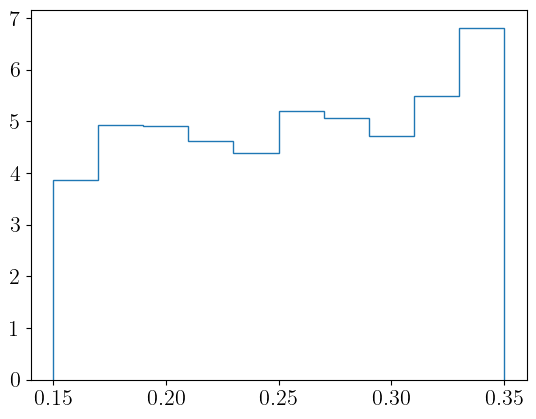

In [12]:
weights = logl_values["2massj"] - logl_values["2massj"].max()
weights = np.exp(weights)
weights /= np.sum(weights)

mask = possis_params[:,6] <= np.pi/4

plt.hist(possis_params[mask,2], weights=weights[mask], density=True, bins=10, histtype="step")
plt.show()

/tmp/ipykernel_24786/2989771543.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


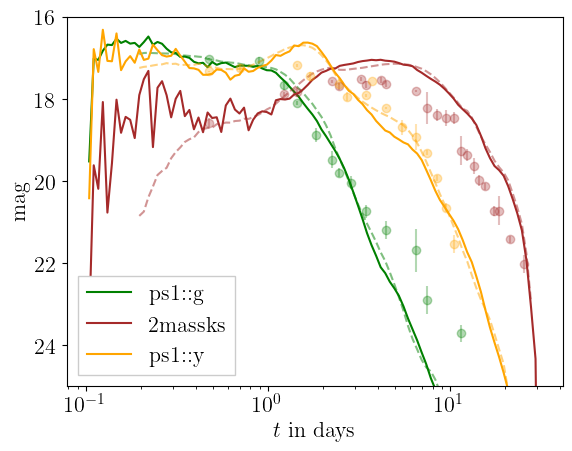

In [20]:
def plot_lc(ax, filt, color, ind=19748):
    params = dict(zip(parameter_names, possis_params[ind]), luminosity_distance=43.583656, redshift=0.009727)
    ax.plot(times, possis_mags[filt][ind] , color=color, label=filt)

    model_t, model_mag = model.predict(params)
    ax.plot(model_t, model_mag[filt], color=color, alpha=0.5, linestyle="dashed")
    ax.errorbar(data[filt][:,0]-trigger_time, data[filt][:,1], yerr=data[filt][:,2], color=color, alpha=0.3, fmt="o")

ind = 19748

fig, ax = plt.subplots(1,1)

plot_lc(ax, "ps1::g", color="green", ind=ind)
plot_lc(ax, "2massks", color="brown", ind=ind)
plot_lc(ax, "ps1::y", color="orange", ind=ind)

#for color, filt in zip(["darkred", "brown", "darkorange", "orange", "yellow", "pink", "red", "green", "blue"], ["2massks", "2massh", "2massj", "ps1::y", "ps1::z", "ps1::i", "ps1::r", "ps1::g", "sdssu"]):
#    plot_lc(ax, filt, color=color, ind=19748)

ax.invert_yaxis()
ax.set_xscale("log")
ax.legend(fancybox=False, framealpha=1)
ax.set_xlabel("$t$ in days")
ax.set_ylabel("mag")
ax.set_ylim((25, 16))
fig.show()



In [14]:
possis_params[19748]

array([-1.32790214,  0.26      ,  0.35      , -0.95860731,  0.06      ,
        0.35      ,  1.26610367])

## Corner

In [15]:
import corner
import pandas as pd

from fiesta.plot import latex_labels

pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

In [16]:
posterior = pd.DataFrame(dict(np.load("./Bu2025/posterior.npz")))

In [17]:
var_names = ["inclination_EM", "log10_mej_dyn", "v_ej_dyn", "Ye_dyn", "log10_mej_wind", "v_ej_wind", "Ye_wind"]
labels = [latex_labels.get(p, p) for p in var_names]

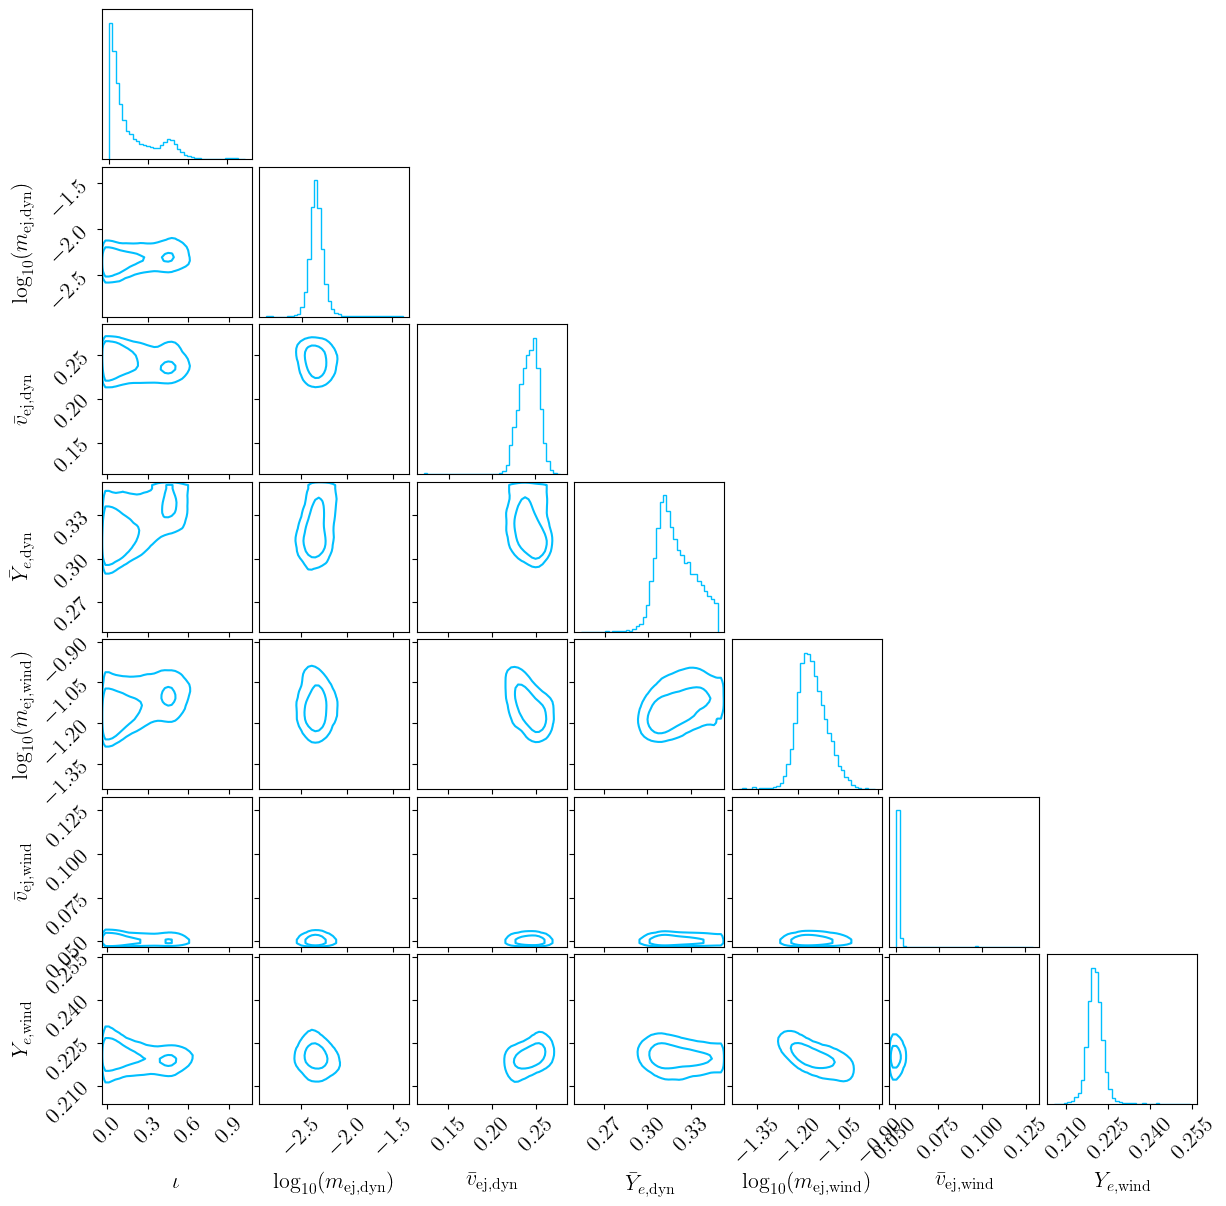

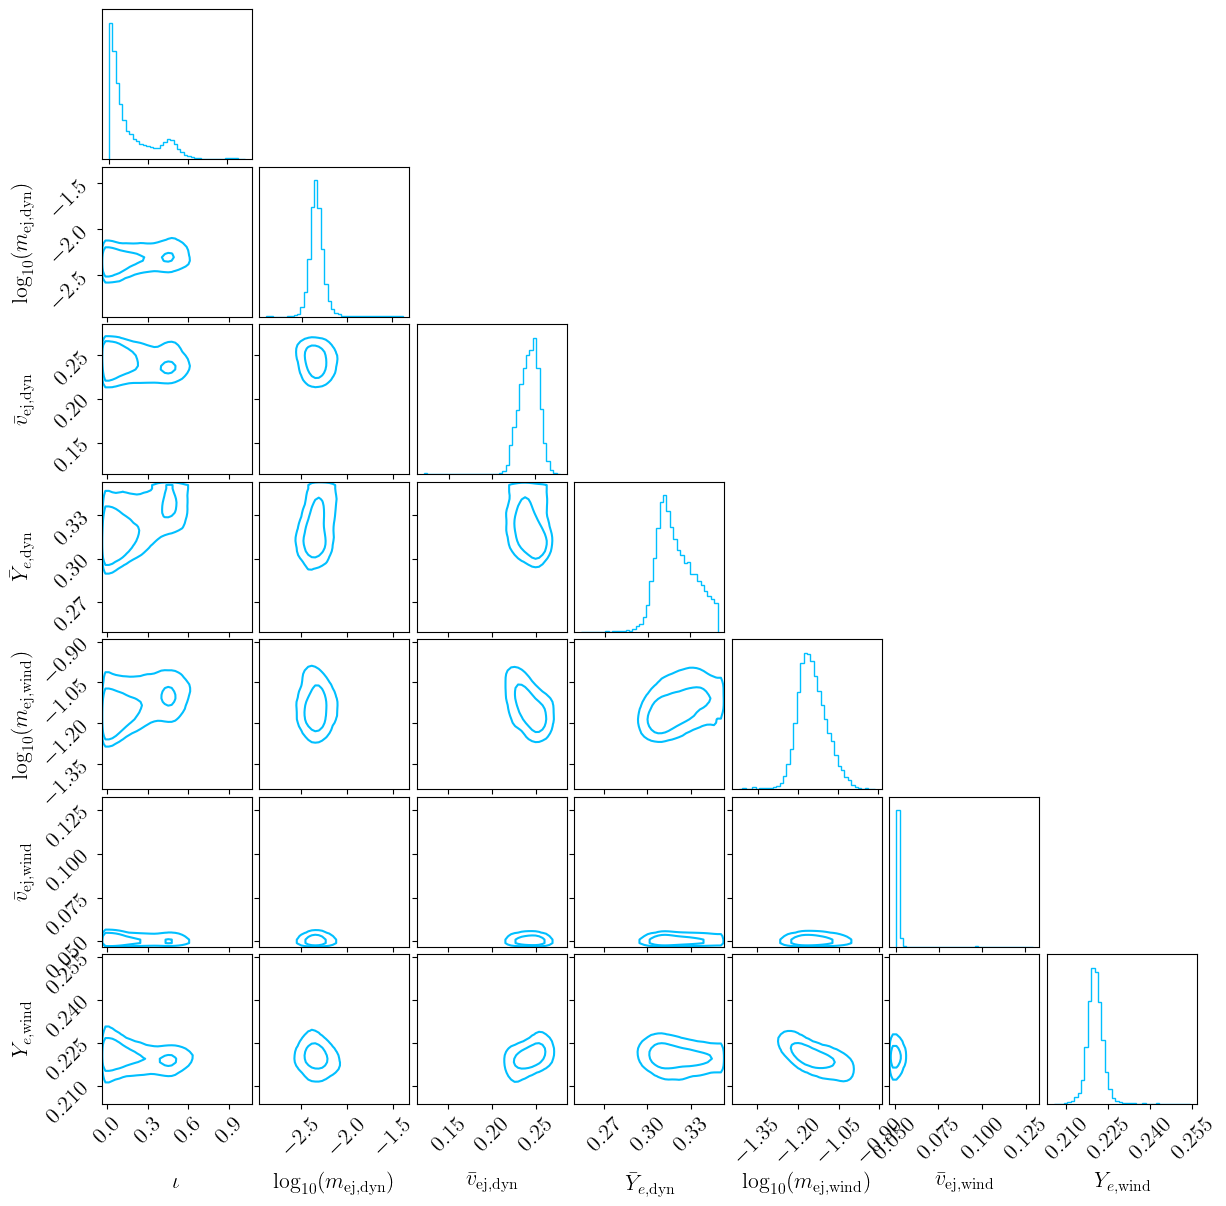

In [8]:
fig, ax = plt.subplots(len(var_names), len(var_names), figsize = (12, 12))

corner.corner(posterior[var_names], 
              fig=fig,
              color = "deepskyblue",
              labelpad = 0.15,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))